In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../output/stage2/exp005.py/20231007110138_gtelarge_l90_s3_maxlen256_bs2_OpenAssistant/reward-model-deberta-v3-large-v2/valid_predictions.csv")

In [3]:
df_retrieval = pd.read_feather( "../output/context_pipeline/stage1/exp009.py/20231008023723_gte-base_wikiall_without_sep_targetprompt_and_choice_without_sep_token_length90_stride_sentence3_drop_categoryTrue_all/valid.feather")

In [4]:
df = pd.merge(df, df_retrieval)

In [5]:
df[["fold0_A", "fold0_B", "fold0_C", "fold0_D", "fold0_E"]].values

array([[-2.7070312 , -1.9306641 , -3.4375    ,  5.515625  , -4.7304688 ],
       [-3.4902344 , -5.796875  , -2.1289062 , -1.3896484 , -1.6103516 ],
       [-2.296875  , -0.83251953, -3.6328125 , -3.9238281 , -4.5273438 ],
       ...,
       [ 8.7265625 ,  9.1875    ,  3.5078125 ,  3.7363281 ,  2.7148438 ],
       [ 2.8925781 ,  1.2978516 ,  1.7382812 ,  5.5664062 , -0.07904053],
       [ 1.3652344 , -0.0508728 ,  7.40625   ,  0.33618164,  1.7802734 ]])

In [6]:
df[["fold0_A", "fold0_B", "fold0_C", "fold0_D", "fold0_E"]].values.argsort(axis=1)

array([[4, 2, 0, 1, 3],
       [1, 0, 2, 4, 3],
       [4, 3, 2, 0, 1],
       ...,
       [4, 2, 3, 0, 1],
       [4, 1, 2, 0, 3],
       [1, 3, 0, 4, 2]])

In [7]:
for i in range(5):
    df[f"pred_{i+1}"] = df[["fold0_A", "fold0_B", "fold0_C", "fold0_D", "fold0_E"]].values.argsort(axis=1)[:, -i-1]
    df[f"pred_{i+1}"] = df[f"pred_{i+1}"].map({
        0: "A", 1: "B", 2: "C", 3: "D", 4: "E"
    })

In [8]:
# df["pred_1"] = df[["fold0_A", "fold0_B", "fold0_C", "fold0_D", "fold0_E"]].values.argmax(axis=1)
# df["pred_1"] = df["pred_1"].map({
#     0: "A", 1: "B", 2: "C", 3: "D", 4: "E"
# })

In [9]:
df["correct"] = df["answer"] == df["pred_1"]

In [10]:
def correct_idx(series):
    for i in [1, 2, 3, 4, 5]:
        if series["answer"] == series[f"pred_{i}"]:
            return i
df["correct_idx"] = df.apply(correct_idx, axis=1)

In [11]:
df["score"] = df["correct_idx"].map({1: 1, 2: 1/2, 3: 1/3, 4: 0, 5: 0})

In [12]:
df.groupby("source")["score"].describe()

,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
eval300,300.0,0.812778,0.309703,0.0,0.5,1.0,1.0,1.0
test,200.0,0.973333,0.127730,0.0,1.0,1.0,1.0,1.0


In [13]:
df.groupby("source")["score"].describe().to_csv("bbbb.csv")

In [14]:
import matplotlib.pyplot as plt

In [15]:
df["max"] = df[["fold0_A", "fold0_B", "fold0_C", "fold0_D", "fold0_E"]].max(axis=1)

correct_idx
1    Axes(0.125,0.11;0.775x0.77)
2    Axes(0.125,0.11;0.775x0.77)
3    Axes(0.125,0.11;0.775x0.77)
4    Axes(0.125,0.11;0.775x0.77)
5    Axes(0.125,0.11;0.775x0.77)
Name: max, dtype: object

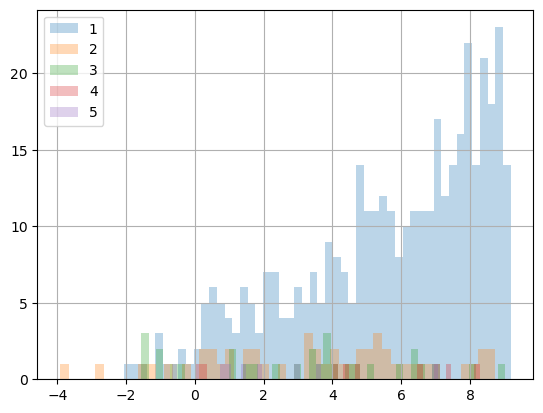

In [16]:
df.groupby("correct_idx")["max"].hist(alpha=0.3, legend=True, bins=50)

In [17]:
df.groupby("source")["max"].describe()

,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
eval300,300.0,4.567076,2.843562,-3.921875,2.272949,4.851562,6.887695,9.101562
test,200.0,6.280401,2.655583,-2.064453,5.063477,7.123047,8.302734,9.187500


In [18]:
df["correct"].value_counts()

True     404
False     96
Name: correct, dtype: int64

In [19]:
df_wrong = df[~df["correct"]]
for source, df_wrong_ in df_wrong.groupby("source"):
    for i in range(5):
        series = df_wrong_.iloc[i]
        print("\n\n=================================")
        print(f"wrong {i}: {series.name}, source={series.source}")
        print("=================================")

        print("prompt:")
        print(series["prompt"])
        for option in "ABCDE":
            print(f"{option}: {series[option]}")

        print("\n-----------------------------------")
        for j in range(5):
            print(f"** retrieval {j}: {series['searched_ids'][j]} **")
            print(series[f"searched_wiki_id_{j}"])
        print("\n-----------------------------------")        
        print(f"answer: {series['answer']}")
        print(f"prediction:")
        display(pd.DataFrame([series])[["fold0_A", "fold0_B", "fold0_C", "fold0_D", "fold0_E"]])



wrong 0: 2, source=eval300
prompt:
What is the significance of the faint Hα emission lines detected in the spectrum of 3 Geminorum?
A: The emission lines indicate that 3 Geminorum is a bright supergiant (luminosity class Ia).
B: The emission lines indicate that 3 Geminorum is a normal supergiant (luminosity class Ib).
C: The emission lines indicate that 3 Geminorum is a small amplitude pulsating variable.
D: The emission lines indicate that 3 Geminorum is a blue supergiant star.
E: The emission lines indicate that 3 Geminorum is a close double star.

-----------------------------------
** retrieval 0: 2013872 **
#Eta Geminorum
 Due to the appearance of the spectrum, the spectroscopic companion is suspected to be a fainter M-class star. Since the secondary star alone would be too small to cause the observed eclipses, it is probably surrounded by a circumstellar disk. The luminous main component of η Geminorum is an asymptotic giant branch star, a highly evolved cool luminous star that

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
2,-2.296875,-0.83252,-3.632812,-3.923828,-4.527344




wrong 1: 7, source=eval300
prompt:
What is a non-relativistic spacetime in physics?
A: A mathematical model that fuses n-dimensional space and m-dimensional time into a single continuum other than the (3+1) model used in relativity theory, only if it deviates from (3+1) dimensionality.
B: A mathematical model that fuses n-dimensional space and m-dimensional time into a single continuum other than the (3+1) model used in relativity theory, only if it does not obey the postulates of special or general relativity.
C: A mathematical model that fuses n-dimensional space and m-dimensional time into a single continuum other than the (3+1) model used in relativity theory, only if it deviates from (3+1) dimensionality and does not obey the postulates of special or general relativity.
D: A mathematical model that fuses n-dimensional space and m-dimensional time into a single continuum other than the (3+1) model used in relativity theory, regardless of whether it satisfies the postulates of spe

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
7,5.0625,3.044922,5.222656,8.367188,5.21875




wrong 2: 15, source=eval300
prompt:
Which of the following statements accurately describes the Weinberg-Witten theorem?
A: The theorem states that massless particles with spin j > 1/2 cannot carry a Lorentz-covariant current.
B: The theorem states that massless particles with helicity |h| > 1 cannot have nonzero charges associated with a conserved stress-energy tensor.
C: The theorem states that the graviton (j = 2) cannot be a composite particle in a relativistic quantum field theory.
D: The theorem states that massless particles with helicity |h| > 1/2 cannot have nonzero charges associated with a conserved 4-vector current.
E: The theorem states that massless particles with spin j > 1 cannot carry a Lorentz-covariant stress-energy.

-----------------------------------
** retrieval 0: 23535 **
#Photon
 The quanta of an Abelian gauge field must be massless, uncharged bosons, as long as the symmetry is not broken; hence, the photon is predicted to be massless, and to have zero electr

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
15,2.978516,-1.082031,1.521484,-0.689453,0.13623




wrong 3: 25, source=eval300
prompt:
Which of the following statements accurately describes a TI-polaron?
A: A TI-polaron is a type of elementary particle that is formed by the interaction between an electron and a phonon.
B: A TI-polaron is a quasiparticle in solid-state physics that has a ground state energy lower than that of a Pekar polaron.
C: A TI-polaron is a localized state of an electron-phonon system with a delocalized electron density and phonon amplitudes.
D: A TI-polaron is a type of elementary particle that has a non-zero induced polarization charge.
E: A TI-polaron is a self-trapped state of an electron-phonon system with a localized electron density and phonon amplitudes.

-----------------------------------
** retrieval 0: 50252496 **
#Polar metal
A polar metal, metallic ferroelectric, or ferroelectric metal is a metal that contains an electric dipole moment. Its components have an ordered electric dipole. Such metals should be unexpected, because the charge should co

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
25,-0.262695,3.183594,0.304932,-6.089844,-4.378906




wrong 4: 26, source=eval300
prompt:
What is the principle behind an acousto-optical spectrometer (AOS)?
A: AOS uses a piezoelectric transducer to generate an acoustic wave in a crystal, which modulates the refractive index and induces a phase grating, resulting in the diffraction of light.
B: AOS uses a single linear diode array (CCD) to generate an acoustic wave in a crystal, which modulates the refractive index and induces a phase grating, resulting in the diffraction of light.
C: AOS uses ultrasonic waves to generate an acoustic wave in a crystal, which modulates the refractive index and induces a phase grating, resulting in the diffraction of light.
D: AOS uses a collimated laser beam to generate an acoustic wave in a crystal, which modulates the refractive index and induces a phase grating, resulting in the diffraction of light.
E: AOS uses imaging optics to generate an acoustic wave in a crystal, which modulates the refractive index and induces a phase grating, resulting in the

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
26,7.800781,-0.532227,7.707031,3.845703,1.933594




wrong 0: 302, source=test
prompt:
Which of the following statements accurately describes the origin and significance of the triskeles symbol?
A: The triskeles symbol was reconstructed as a feminine divine triad by the rulers of Syracuse, and later adopted as an emblem. Its usage may also be related to the Greek name of Sicily, Trinacria, which means "having three headlands." The head of Medusa at the center of the Sicilian triskeles represents the three headlands.
B: The triskeles symbol is a representation of three interlinked spirals, which was adopted as an emblem by the rulers of Syracuse. Its usage in modern flags of Sicily has its origins in the ancient Greek name for the island, Trinacria, which means "Sicily with three corners." The head of Medusa at the center is a representation of the island's rich cultural heritage.
C: The triskeles symbol is a representation of a triple goddess, reconstructed by the rulers of Syracuse, who adopted it as an emblem. Its significance lies i

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
302,3.876953,4.472656,1.507812,5.980469,0.678223




wrong 1: 321, source=test
prompt:
What is the propagation constant in sinusoidal waves?
A: The propagation constant is a measure of the amplitude of the sinusoidal wave that varies with distance.
B: The propagation constant is a real number that remains constant with distance due to the phase change in the sinusoidal wave.
C: The propagation constant is a real number that varies with distance due to the phase change in the sinusoidal wave.
D: The propagation constant is a complex number that varies with distance due to the phase change in the sinusoidal wave.
E: The propagation constant is a complex number that remains constant with distance due to the phase change in the sinusoidal wave.

-----------------------------------
** retrieval 0: 41586 **
#Propagation constant
The propagation constant of a sinusoidal electromagnetic wave is a measure of the change undergone by the amplitude and phase of the wave as it propagates in a given direction. The quantity being measured can be the 

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
321,-2.408203,-1.070312,1.629883,1.220703,-0.398926




wrong 2: 328, source=test
prompt:
What is the evidence for the existence of a supermassive black hole at the center of the Milky Way galaxy?
A: The Milky Way galaxy has a supermassive black hole at its center because of the bright flare activity observed near Sagittarius A*. The radius of the central object must be less than 17 light-hours, because otherwise S2 would collide with it. Observations of the star S14 indicate that the radius is no more than 6.25 light-hours, about the diameter of Uranus' orbit. No known astronomical object other than a black hole can contain 4.0 million M☉ in this volume of space.
B: The Milky Way galaxy has a supermassive black hole at its center because the star S14 follows an elliptical orbit with a period of 15.2 years and a pericenter of 17 light-hours from the center of the central object. From the motion of star S14, the object's mass can be estimated as 4.0 million M☉, or about 7.96×1036 kg. The radius of the central object must be less than 17 li

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
328,0.196655,2.453125,1.375,1.398438,1.748047




wrong 3: 359, source=test
prompt:
What are the Navier-Stokes equations?
A: The Navier-Stokes equations are partial differential equations that describe the motion of viscous fluid substances, expressing momentum balance and conservation of mass for Newtonian fluids.
B: The Navier-Stokes equations are partial differential equations that describe the motion of viscous fluid substances, expressing momentum balance and conservation of mass for non-Newtonian fluids.
C: The Navier-Stokes equations are partial differential equations that describe the motion of non-viscous fluid substances, expressing momentum balance and conservation of mass for Newtonian fluids.
D: The Navier-Stokes equations are algebraic equations that describe the motion of non-viscous fluid substances, expressing momentum balance and conservation of mass for Newtonian fluids.
E: The Navier-Stokes equations are algebraic equations that describe the motion of viscous fluid substances, expressing momentum balance and cons

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
359,3.21875,-1.520508,1.44043,2.828125,5.753906




wrong 4: 368, source=test
prompt:
What is the Maxwell's Demon thought experiment?
A: A thought experiment in which a demon guards a microscopic trapdoor in a wall separating two parts of a container filled with different gases at equal temperatures. The demon selectively allows molecules to pass from one side to the other, causing an increase in temperature in one part and a decrease in temperature in the other, contrary to the second law of thermodynamics.
B: A thought experiment in which a demon guards a macroscopic trapdoor in a wall separating two parts of a container filled with different gases at different temperatures. The demon selectively allows molecules to pass from one side to the other, causing a decrease in temperature in one part and an increase in temperature in the other, in accordance with the second law of thermodynamics.
C: A thought experiment in which a demon guards a microscopic trapdoor in a wall separating two parts of a container filled with the same gas at 

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
368,6.769531,2.390625,6.34375,5.300781,3.650391


In [40]:
df_wrong = df[df["correct"]]
for source, df_wrong_ in df_wrong.groupby("source"):
    for i in range(2):
        series = df_wrong_.iloc[i]
        print("\n\n=================================")
        print(f"wrong {i}: {series.name}, source={series.source}")
        print("=================================")

        print("prompt:")
        print(series["prompt"])
        for option in "ABCDE":
            print(f"{option}: {series[option]}")

        print("\n-----------------------------------")
        for j in range(5):
            print(f"** retrieval {j}: {series['searched_ids'][j]} **")
            print(series[f"searched_wiki_id_{j}"])
        print("\n-----------------------------------")        
        print(f"answer: {series['answer']}")
        print(f"prediction:")
        display(pd.DataFrame([series])[["fold0_A", "fold0_B", "fold0_C", "fold0_D", "fold0_E"]])



wrong 0: 0, source=1
prompt:
When was the album "Bodysong" by Jonny Greenwood released?
A: October 27, 2004 in the UK and February 24, 2003 in the United States.
B: October 28, 2003 in the UK and February 23, 2004 in the United States.
C: October 27, 2003 in the UK and February 24, 2004 in the United States.
D: October 24, 2004 in the UK and February 27, 2003 in the United States.
E: October 24, 2003 in the UK and February 27, 2004 in the United States.

-----------------------------------
** retrieval 0: 1072228 **
#Bodysong (album)
Bodysong is the debut solo album by Radiohead guitarist Jonny Greenwood. It is the soundtrack to the documentary film of the same name. It was released on October 27, 2003 in the UK and on February 24, 2004 in the United States. It was digitally remastered and reissued on CD and vinyl on 18 May 2018. Greenwood's brother, Radiohead bassist Colin, plays bass on the album. It is notable for be the first "solo" album released by any member of Radiohead. Curr

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
0,-1.336914,1.046875,8.664062,-2.169922,1.1875




wrong 1: 1, source=1
prompt:
What is the primary function of mitochondria?
A: Cell death and apoptosis
B: Membrane formation and organelle structure
C: Energy generation through respiration
D: Cell differentiation and specialization
E: Cell signaling and communication

-----------------------------------
** retrieval 0: 6339 **
#Cell biology
 Mitochondria are commonly referred to as the cell's "powerhouses" because of their capacity to effectively produce ATP which is essential to maintain cellular homeostasis and metabolism. Moreover, researchers have gained a better knowledge of mitochondria's significance in cell biology because of the discovery of cell signaling pathways by mitochondria which are crucial platforms for cell function regulation such as apoptosis. Its physiological adaptability is strongly linked to the cell mitochondrial channel's ongoing reconfiguration through a range of mechanisms known as mitochondrial membrane dynamics, which include endomembrane fusion and fr

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
1,-6.957031,-7.453125,4.769531,-7.746094,-7.363281




wrong 0: 2714, source=11
prompt:
Asteroids, comets, and planets move around the sun in curved paths called what?
A: orbits
B: ellipticals
C: None
D: satellites
E: curves

-----------------------------------
** retrieval 0: 34809573 **
#Glossary of astronomy
 Kelvin–Helmholtz mechanism Kepler orbit The motion of one orbiting body relative to another, as an ellipse, parabola, or hyperbola, which forms a two-dimensional orbital plane (or sometimes a straight line) in three-dimensional space. Kepler orbits are idealized mathematical constructions which consider only the point-like gravitational attraction of two bodies, neglecting more complex orbital perturbations that may exist in reality. Kuiper belt A circumstellar disc of small Solar System bodies such as asteroids, trojans, and centaurs in the outer Solar System, extending between 30 and 50 AU from the Sun. It is similar to the asteroid belt but far larger, and is home to several dwarf planets, including Pluto Lagrangian point Any 

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
2714,9.015625,3.59375,-7.613281,-7.554688,-3.644531




wrong 1: 2715, source=11
prompt:
The lattice energy is usually the most important energy factor in determining the stability of what?
A: ionic compound
B: magnetic compound
C: The reliquary contains a finger that was believed to belong to John the Baptist, but its authenticity has been questioned.
D: harmonic compound
E: saline compound

-----------------------------------
** retrieval 0: 3848049 **
#Lattice energy
In chemistry, the lattice energy is the energy change upon formation of one mole of a crystalline ionic compound from its constituent ions, which are assumed to initially be in the gaseous state. It is a measure of the cohesive forces that bind ionic solids. The size of the lattice energy is connected to many other physical properties including solubility, hardness, and volatility. Since it generally cannot be measured directly, the lattice energy is usually deduced from experimental data via the Born–Haber cycle. The concept of lattice energy was originally applied to the

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
2715,4.964844,-6.542969,-7.269531,-5.191406,-1.12793




wrong 0: 300, source=2
prompt:
What is the subject matter of the painting, "Portrait of Madame Ingres" by Jean-Auguste-Dominique Ingres?
A: The painting is a portrait of the artist's first wife.
B: The painting is a depiction of a mythological scene.
C: The painting is a self-portrait of the artist, Jean-Auguste-Dominique Ingres.
D: The painting is a portrait of the artist's second wife, Delphine Ramel.
E: The painting is an abstract representation of emotions.

-----------------------------------
** retrieval 0: 55326740 **
#Portrait of Madame Ingres
Portrait of Madame Ingres is a late period oil on canvas painting by the French Neoclassical artist Jean-Auguste-Dominique Ingres, completed in 1859. Depicting his second wife Delphine Ramel (he was widowed in 1849), it is Ingres' final painted portrait, apart from two self-portraits. It was probably painted to accompany Ingres's self-portrait of the same year, now in the Fogg Art Museum, Boston. Delphine was the daughter of Dominique R

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
300,-6.820312,-9.640625,-7.109375,6.671875,-8.804688




wrong 1: 301, source=2
prompt:
When did the Ole Miss-Tulane football rivalry begin and what is the current series record?
A: The Ole Miss-Tulane football rivalry began in 1895, and Tulane leads the series 29-42.
B: The Ole Miss-Tulane football rivalry began in 1893, and Ole Miss leads the series 42-29.
C: The Ole Miss-Tulane football rivalry began in 1895, and Ole Miss leads the series 29-42.
D: The Ole Miss-Tulane football rivalry began in 1896, and Ole Miss leads the series 29-42.
E: The Ole Miss-Tulane football rivalry began in 1893, and Tulane leads the series 42-29.

-----------------------------------
** retrieval 0: 46824775 **
#Ole Miss–Tulane football rivalry
The Ole Miss–Tulane football rivalry is an American college football rivalry between the Ole Miss Rebels and Tulane Green Wave.[citation needed] The rivalry began in 1893. Ole Miss leads the series 42–29. It is Tulane's second-oldest football rivalry, one week younger than the Battle for the Rag. It is Ole Miss' oldest 

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
301,-2.525391,8.726562,-1.339844,-1.827148,0.210205




wrong 0: 600, source=3
prompt:
What can be inferred about the goose's owner from the story?
A: The owner was greedy and demanding.
B: The owner valued the goose's well-being over profit.
C: The owner was afraid of the goose.
D: The owner misunderstood the goose's capabilities.
E: The owner was kind and patient.

-----------------------------------
** retrieval 0: 1798486 **
#The Golden Goose
 Over time, he brought them more feathers to sell, and they were living in a continuous state of comfort and peace; until one day, when his wife became greedy and decided to formulate a plan to steal all of his feathers for money. His daughters did not like the idea of stealing his feathers, so they did not agree to the idea. Alas, the next time the golden goose came back, his wife plucked all of his feathers. When she did this, the feathers immediately changed from golden feathers to white crane feathers The wife waited for the golden feathers to grow back, but they never did; they grew back whi

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
600,-3.458984,-5.503906,-7.425781,-4.324219,-5.605469




wrong 1: 601, source=3
prompt:
According to the provided Wikipedia excerpt, when was the video for the song "Il primo giorno d'estate" officially released?
A: 1 July 2014
B: 5 July 2014
C: 3 July 2014
D: 2 July 2014
E: 4 July 2014

-----------------------------------
** retrieval 0: 44110425 **
#Il primo giorno d'estate
 Music and lyrics to the song were written by Italian songwriters Luca Mattioni and Mario Cianchi. The track is basically a pop song with lyrics and atmosphere recalling the typical lightheartedness of summer. The music video was shot in Marina di Ravenna, Italy in June 2014. From her Facebook page, Violetta's fans were offered to take part in the shooting of the video which took place mostly at the "Hana Bi" beach and in other locations of the small sea town The video was officially released on 4 July 2014. To date the song was performed live only once, during Violetta's show at "Galleria Porta di Roma" in Rome. In that occasion Violetta performed the song with the s

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
601,-2.044922,-2.636719,-1.40625,-1.291992,8.5




wrong 0: 921, source=4
prompt:
What was Eddie Large primarily known for?
A: Eddie Large was primarily known as an athlete.
B: Eddie Large was primarily known as a politician.
C: Eddie Large was primarily known as a comedian.
D: Eddie Large was primarily known as a singer.
E: Eddie Large was primarily known as a magician.

-----------------------------------
** retrieval 0: 1112571 **
#Eddie Large
Edward Hugh McGinnis (25 June 1941 – 2 April 2020), better known by the stage name Eddie Large, was a British comedian. He was best known as one half of the double act Little and Large, with Syd Little (the stage name of Cyril Mead). Large was born Edward Hugh McGinnis in Glasgow in 1941. His father Teddy served as a Petty Officer in the Royal Navy during World War II and after he returned from the war the family moved to a tenement in Oatlands. When he was nine years old, the family moved again to Manchester, where he attended Claremont Road Primary School and a grammar school. He played fo

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
921,-8.351562,-9.390625,2.191406,-5.277344,-8.695312




wrong 1: 922, source=4
prompt:
When was the album "Merry Clayton" released?
A: 1973
B: 1971
C: 1970
D: 1969
E: 1972

-----------------------------------
** retrieval 0: 60035657 **
#Merry Clayton (album)
Merry Clayton is the third studio album by American soul singer Merry Clayton, released in 1971 on the Ode Records label. AllMusic Guide's editorial board gave Merry Clayton four out of five stars and have noted it as an album pick in her catalogue. Billboard called the music "excellent" with "potential to be a monster" commercial success. Merry Clayton – vocals Wilton Felder – bass Paul Humphrey – drums David T. Walker – guitar Billy Preston, Carole King, Clarence McDonald, Jerry Peters, Joe Sample – keyboards Abigail Haness, Jerry Peters, Merry Clayton, Patrice Holloway, James Cleveland – backing vocals Curtis Amy – saxophone Lou Adler – production Jim McCrary – photography Hank Cicalo – engineering Merry Clayton topped out at number 180 on the Billboard 200 and spent 11weeks on th

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
922,-3.875,4.566406,-2.886719,-2.96875,-3.041016




wrong 0: 717, source=5
prompt:
What is the population of Jangipara CD Block?
A: Jangipara CD Block has a population of 45,000 people.
B: Jangipara CD Block has a population of 129 mouzas.
C: Jangipara CD Block has a population of 128 inhabited villages.
D: Jangipara CD Block has a population of 10 gram panchayats.
E: Jangipara CD Block has a population of 177 gram sansads (village councils).

-----------------------------------
** retrieval 0: 21377680 **
#Jangipara (community development block)
 The only Census Town in Jangipara CD Block is (2011 census figure in brackets): Rajbalhat (16,479). Large villages (with 4,000+ population) in Jangipara CD Block are (2011 census figures in brackets): Borhal (4,548), Krishnanagar (10,520), Kotalpur (6,948), Furfura (7,407), Mandalika (5,946) and Laksmanpur (4,008). Other villages in Jangipara CD Block include (2011 census figures in brackets): Antpur (2,623), Jangipara (2,700). As per the 2011 census the total number of literates in Jangipar

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
717,-3.039062,-5.003906,-4.621094,-7.46875,-6.398438




wrong 1: 719, source=5
prompt:
What is the population of Jangipara CD Block?
A: Jangipara CD Block has a population of 45,000 people.
B: Jangipara CD Block has a population of 129 mouzas.
C: Jangipara CD Block has a population of 128 inhabited villages.
D: Jangipara CD Block has a population of 10 gram panchayats.
E: Jangipara CD Block has a population of 177 gram sansads (village councils).

-----------------------------------
** retrieval 0: 21377680 **
#Jangipara (community development block)
 The only Census Town in Jangipara CD Block is (2011 census figure in brackets): Rajbalhat (16,479). Large villages (with 4,000+ population) in Jangipara CD Block are (2011 census figures in brackets): Borhal (4,548), Krishnanagar (10,520), Kotalpur (6,948), Furfura (7,407), Mandalika (5,946) and Laksmanpur (4,008). Other villages in Jangipara CD Block include (2011 census figures in brackets): Antpur (2,623), Jangipara (2,700). As per the 2011 census the total number of literates in Jangipar

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
719,-3.039062,-5.003906,-4.621094,-7.46875,-6.398438




wrong 0: 1514, source=6
prompt:
How can a plasma channel be formed?
A: By increasing the pressure inside a dielectric until it reaches the breakdown voltage
B: By applying a high voltage across a plasma
C: By using a laser-induced plasma channel
D: By subjecting an atmospheric gas to a high-powered laser operating at a specific frequency
E: By immersing a dielectric in a conductive medium

-----------------------------------
** retrieval 0: 4923796 **
#Plasma channel
 With a high-powered laser that operates at a certain frequency that will provide enough energy for an atmospheric gas to break into its ions, or form a plasma, such as in a Laser-Induced Plasma Channel, for example in an electrolaser. With a voltage higher than the dielectric breakdown voltage applied across a dielectric, and dielectric breakdown occurs. A plasma channel has a low electrical resistance and, once formed, will permit continuous current flow if the energy source that heats the plasma can be maintained. Unl

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
1514,-3.519531,-2.226562,0.087158,4.914062,-5.460938




wrong 1: 1515, source=6
prompt:
Which of the following statements accurately describes the relationship between gestational age and embryonic age during human prenatal development?
A: Gestational age measures the actual age of the embryo or fetus from the time of fertilization, while embryonic age estimates the time that has passed since the onset of the last menstruation.
B: Gestational age measures the time that has passed since fertilization, while embryonic age estimates the time that has passed since implantation.
C: Gestational age and embryonic age are interchangeable terms used to describe the age of the embryo or fetus during prenatal development.
D: Gestational age and embryonic age are two different methods of estimating the age of the embryo or fetus during prenatal development.
E: Gestational age measures the time that has passed since the onset of the last menstruation, while embryonic age measures the actual age of the embryo or fetus from the time of fertilization.

-

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
1515,1.02832,-0.812012,-3.261719,1.807617,8.367188




wrong 0: 1814, source=7
prompt:
When was the biannual international conference for sports engineering established?
A: 1999
B: 1950
C: 1980
D: 2005
E: 1975

-----------------------------------
** retrieval 0: 48188462 **
#Sports engineering
 Starting in 1999, the biannual international conference for sports engineering was established to commemorate achievements in the field. Presently, the journal entitled “Sports Engineering,” details the innovations and research projects that sports engineers are working on. The study of sports engineering requires an understanding of a variety of engineering topics including physics, mechanical engineering, materials science, and biomechanics. Many practitioners hold degrees in those topics rather than in sports engineering specifically Specific study programs in sports engineering and technology are becoming more common at the graduate level, and also at the undergraduate level in Europe. Sports engineers also employ computational engineering too

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
1814,4.988281,-5.429688,-4.554688,-4.789062,-4.078125




wrong 1: 1815, source=7
prompt:
Which field does queueing theory find applications in?
A: Telecommunication
B: Traffic engineering
C: Computing
D: Project management
E: All of the above

-----------------------------------
** retrieval 0: 50578 **
#Queueing theory
Queueing theory is the mathematical study of waiting lines, or queues. A queueing model is constructed so that queue lengths and waiting time can be predicted. Queueing theory is generally considered a branch of operations research because the results are often used when making business decisions about the resources needed to provide a service. Queueing theory has its origins in research by Agner Krarup Erlang, who created models to describe the system of incoming calls at the Copenhagen Telephone Exchange Company. These ideas have since seen applications in telecommunication, traffic engineering, computing, project management, and particularly industrial engineering, where they are applied in the design of factories, shops

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
1815,-1.28418,-1.736328,-3.859375,-2.181641,8.4375




wrong 0: 2115, source=8
prompt:
What happens when the set pressure of a relief valve is exceeded?
A: The valve closes and stops the flow of fluid
B: The pressure inside the vessel continues to rise
C: The valve becomes the path of least resistance
D: The pressure in the system is maintained at a constant level
E: The valve releases naked combustion gases into the atmosphere

-----------------------------------
** retrieval 0: 984070 **
#Relief valve
 Excess pressure is relieved by allowing the pressurized fluid to flow from an auxiliary passage out of the system. The relief valve is designed or set to open at a predetermined set pressure to protect pressure vessels and other equipment from being subjected to pressures that exceed their design limits. When the set pressure is exceeded, the relief valve becomes the "path of least resistance" as the valve is forced open and a portion of the fluid is diverted through the auxiliary route. In systems containing flammable fluids, the divert

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
2115,-4.335938,-1.517578,6.832031,-3.953125,-1.268555




wrong 1: 2116, source=8
prompt:
How is directed self-assembly (DSA) used in the semiconductor industry?
A: To accurately control the assembly of micro and nano particles
B: To build tissues in tissue engineering
C: To increase the resolution and fit in more gates
D: To increase the storage densities in hard drives
E: To mass-produce micro to nano devices and materials

-----------------------------------
** retrieval 0: 49261105 **
#Directed assembly of micro- and nano-structures
 The DSA is not a standalone process, but rather is integrated with traditional manufacturing processes in order to mass-produce micro and nano structures at a lower cost. Directed self-assembly is mostly used in the semiconductor and hard drive industries. The semiconductor industry uses this assembly method in order to be able increase the resolution (trying to fit in more gates), while the hard drive industry uses DSA to manufacture "bit patterned media" according to the specified storage densities. There

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
2116,0.118958,-8.148438,5.933594,-1.285156,2.458984




wrong 0: 2414, source=9
prompt:
Where does digestion of proteins begin? What mix with food to break down proteins? What do proteins break down into?
A: stomach; amylase; HCl; amino acids
B: mouth; pepsin; HCl; fatty acids
C: stomach; lipase; HCl; amino acids
D: stomach; pepsin; HCl; amino acids
E: stomach; amylase; HCl; amino acids

-----------------------------------
** retrieval 0: 1057785 **
#Digestive enzyme
 Pepsinogen is then activated by the stomach acid into its active form, pepsin. Pepsin breaks down the protein in the food into smaller particles, such as peptide fragments and amino acids. Protein digestion, therefore, primarily starts in the stomach, unlike carbohydrate and lipids, which start their digestion in the mouth (however, trace amounts of the enzyme kallikrein, which catabolises certain protein, is found in saliva in the mouth). Gastric lipase: Gastric lipase is an acidic lipase secreted by the gastric chief cells in the fundic mucosa of the stomach It has a pH le

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
2414,-4.234375,-7.054688,-3.019531,0.827637,-4.234375




wrong 1: 2417, source=9
prompt:
What property prevents the ligands of cell-surface receptors from entering the cell?
A: The molecules bind to the extracellular domain.
B: The molecules are hydrophilic and cannot penetrate the hydrophobic interior of the plasma membrane.
C: The molecules are attached to transport proteins that deliver them through the bloodstream to target cells.
D: The ligands are able to penetrate the membrane and directly influence gene expression upon receptor binding.
E: The molecules are attached to transport proteins that deliver them through the bloodstream to target cells.

-----------------------------------
** retrieval 0: 22519313 **
#Cell surface receptor
Cell surface receptors (membrane receptors, transmembrane receptors) are receptors that are embedded in the plasma membrane of cells. They act in cell signaling by receiving (binding to) extracellular molecules. They are specialized integral membrane proteins that allow communication between the cell and

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
2417,0.812012,4.996094,-4.738281,-6.257812,-4.738281




wrong 0: 3014, source=additional_data/MMLU/test.csv
prompt:
What singer appeared in the 1992 baseball film 'A League of Their Own'?
A: Brandy
B: Madonna
C: Garth Brooks
D: Whitney Houston
E: Sister

-----------------------------------
** retrieval 0: 543433 **
#A League of Their Own
A League of Their Own is a 1992 American sports comedy-drama film directed by Penny Marshall that tells a fictionalized account of the real-life All-American Girls Professional Baseball League (AAGPBL). It stars Tom Hanks, Geena Davis, Madonna, Lori Petty, Rosie O'Donnell, Jon Lovitz, David Strathairn, Garry Marshall, and Bill Pullman. It was written by Lowell Ganz and Babaloo Mandel from a story by Kelly Candaele and Kim Wilson. A League of Their Own was a critical and commercial success, grossing over $132.4 million worldwide and garnering acclaim for Marshall's direction and the performances of its ensemble cast. In 2012, the Library of Congress selected it for preservation in the United States Nationa

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
3014,-1.378906,1.716797,-3.654297,-2.808594,-0.012894




wrong 1: 3015, source=additional_data/MMLU/test.csv
prompt:
What are the effects of globalisation on food security?

A: Wealthy countries subsidies and trade barriers make it difficult for developing countries to take advantage of the potential of globalisation for advancing food security.
B: World Trade Organisation rules do not cover agriculture, so globalisation really has no bearing on food security.
C: Supermarkets are so far the only way in which food and agriculture have experienced globalisation.
D: Developing countries need to create publicly-owned food reserves in order to realise the potential benefits.
E: Cindy

-----------------------------------
** retrieval 0: 171866 **
#Agricultural subsidy
 On the other hand, farmers producing fruits and vegetables received no direct subsidies. The environmental impact of meat production is high due to the resource and energy requirements that go into production of feed for livestock throughout their lifespan, for example, a kilogram

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
3015,0.854492,-4.753906,-7.375,-5.390625,-8.070312




wrong 0: 3314, source=additional_data/OpenBookQA-V1-Sep2018/OpenBookQA-V1-Sep2018/Data/Main/train.tsv
prompt:
which one of these animals lives deepest in the ocean?
A: an african parrot
B: gold fish
C: a tuna fish
D: a vampire squid
E: an old tall building

-----------------------------------
** retrieval 0: 4699587 **
#Fish
 More than 5,600 fish species inhabit Neotropical freshwaters alone, such that Neotropical fishes represent about 10% of all vertebrate species on the Earth. Exceptionally rich sites in the Amazon basin, such as Cantão State Park, can contain more freshwater fish species than occur in all of Europe. The deepest living fish in the ocean so far found is the snailfish (Pseudoliparis belyaevi) which was filmed in the Izu-Ogasawara Trench off the coast of Japan at 8,336 meters in August 2022. The fish was filmed by a robotic lander as part of a scientific expedition funded by Victor Vescovo's Caladan Oceanic with the scientific team led by Professor Alan Jamieson of t

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
3314,-9.414062,-8.46875,-8.164062,-4.542969,-9.625




wrong 1: 3315, source=additional_data/OpenBookQA-V1-Sep2018/OpenBookQA-V1-Sep2018/Data/Main/train.tsv
prompt:
What would be easier to burn?
A: A park bench
B: A silver spoon
C: Tupperware
D: An Airplane
E: planetary revolution

-----------------------------------
** retrieval 0: 237243 **
#Portable stove
 There are several different designs that are used but smaller ones are portable and are made of steel and other materials with insulation inside a double-walled design with a chamber for partial biomass gasification and additional mixing of air and wood gas to increase heat output and provide a cleaner, more-complete burn. The advantage of these rocket stoves is their requiring little fuel, such as wood and dry weeds, to cook a meal, and with this less air pollution. The single AA battery operated, fan-driven Sierra "Zip" stove burns small twigs, pinecones, bark, or other small flammable items. The fuel is placed into a small chamber and, with the fan turned on, burns at a high heat

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
3315,-0.515137,-5.402344,-5.207031,-6.792969,-8.953125




wrong 0: 3614, source=additional_data/ScienceQA/test.parquet
prompt:
Which tense does the sentence use?
I tell Jayla my opinions about her music.
A: past tense
B: present tense
C: future tense
D: Both are only physical changes.
E: Does a rubber inner tube sled or a plastic sled go faster down a hill?

-----------------------------------
** retrieval 0: 449612 **
#Present tense
The present tense (abbreviated PRES or PRS) is a grammatical tense whose principal function is to locate a situation or event in the present time. The present tense is used for actions which are happening now. In order to explain and understand present tense, it is useful to imagine time as a line on which the past tense, the present and the future tense are positioned. The term present tense is usually used in descriptions of specific languages to refer to a particular grammatical form or set of forms; these may have a variety of uses, not all of which will necessarily refer to present time. For example, in th

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
3614,-5.089844,2.595703,-8.085938,-9.414062,-6.203125




wrong 1: 3616, source=additional_data/ScienceQA/test.parquet
prompt:
Select the invertebrate.
A: black howler
B: cardinalfish
C: green sea turtle
D: earthworm
E: Tucker's neighbor taught him how to repair a kite.

-----------------------------------
** retrieval 0: 33987832 **
#Calila e Dimna
 The wife insisted on moving their nest to avoid the sea agent, but the husband refused and when the tide came in the sea agent took the nest. The male sandpiper decided to call upon the king of the birds, the phoenix, for help, which he received. The phoenix went with a contingent of birds to attack the sea agent and reclaim the nest, but the sea agent gave it up out of fear and avoided confrontation. Sub-story of sub-story ten - The Turtle and the two ducks - Told by the female sandpiper to the male sandpiper in an effort to convince him to move the nest A turtle lived in a pond with two ducks, but the pond's water levels were decreasing, so the turtle asked the ducks to help him move to anoth

,fold0_A,fold0_B,fold0_C,fold0_D,fold0_E
3616,-8.820312,-5.550781,-7.542969,6.246094,-9.335938
